In [77]:
# PATH
file_path_data = 'data/data_raw/'

# Itération - Projet: Twitter Sentiment Analysis

### Importation des packages nécessaires

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize, pos_tag, sent_tokenize 
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.metrics import classification_report

# I. Importation du jeu de données

In [79]:
data = pd.read_csv(file_path_data + 'twitter_comment.csv',encoding = "ISO-8859-1",
                 names = ["target", "ids", "date", "flag", "user", "text"])

In [80]:
data.shape

(1600000, 6)

# II. Fonctions

In [81]:
def check_df(df):
    """
    Récupérer les informations sur le dataframe df
    """
    print("Le nombre de tweets positifs est:", (df[df.target == 4].shape[0]))
    print("Le nombre de tweets négatifs est:", (df[df.target == 0].shape[0]))
    print("Le nombre de tweets nuls:\n" + str(pd.isnull(df).sum()))
    textes = df.text
    r = re.compile(r"RT")
    count = 0
    for tweet in textes :
        try:  compte = r.finditer(tweet) 
        except : continue
        for m in compte:
            count += 1
    print('Nombre de retweets: '+str(count))

In [82]:
def train_and_test_models(df):
    """
    Entrainer et tester deux modèles de classification sur df
    """
    # Variables explicatifs et cible
    X = df['text']
    y = df.target
    
    # Créer un dictionnaire qui contient les prédictions
    prediction = dict()
    
    # Séparation de data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    
    # Vectorizer
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Régression logistique 
    logreg = linear_model.LogisticRegression(C=0.1, penalty ='l2')
    logreg.fit(X_train, y_train)
    prediction['Logistic'] = logreg.predict(X_test)
    
    #Resultat de Régression logistique 
    print("Evaluation détaillée de la Classification par régression logistique :\n \n" ,classification_report(y_test,prediction['Logistic']))
    confusion_matrix = pd.crosstab(y_test, prediction['Logistic'], rownames=['Classe réelle'],colnames=['Classe prédite'])
    print("La matrice de confusion pour la Classification par régression logistique :\n \n" ,confusion_matrix)
    accuracy = logreg.score(X_test, y_test)
    print("Le score pour la Classification par régression logistique :",accuracy)
    
    print("="*90)
    # Naif bayésien BernoulliNB

    from sklearn.naive_bayes import BernoulliNB
    ber = BernoulliNB().fit(X_train, y_train)
    prediction['Bernoulli'] = ber.predict(X_test)
    
    #Resutat de Naif bayésien BernoulliNB
    print("Evaluation détaillée de la Classification par le modèle naif bayésien BernoulliNB :\n \n" ,classification_report(y_test,prediction['Bernoulli']))
    confusion_matrix = pd.crosstab(y_test, prediction['Bernoulli'], rownames=['Classe réelle'],colnames=['Classe prédite'])
    print("La matrice de confusion pour la Classification par le modèle naif bayésien BernoulliNB :\n \n" ,confusion_matrix)
    accuracy = ber.score(X_test, y_test)
    print("Le score pour la Classification par le modèle naif bayésien BernoulliNB :",accuracy)
    
    return prediction, y_test


In [ ]:
def grid_confusion_matrix(prediction,y_test):
    """
    Créer une grille de matrices de confusion
    """
    classes= (0,4)
    def plot_confusion_matrix(cm, cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        plt.tight_layout()
        plt.ylabel('Vrais labels')
        plt.xlabel('Labels prédits')       
    plt.figure(figsize=(10,10))
    i=0
    for model, predicted in prediction.items():
        i=i+1
        plt.subplot(2,1,i)
        plt.title('Matrice de confusion pour la Classification par: %s'% model)
        cm_model = confusion_matrix(y_test, predicted)
        plot_confusion_matrix(cm_model)

In [ ]:
def courbe_ROC(prediction,y_test):
    '''
    Créer des courbes de ROC
    '''
    cmp = 0
    colors = ['b', 'g']
    plt.figure(figsize=(10,10))
    for model, predicted in prediction.items():
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted,pos_label=4)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp += 1
    plt.title('Comparaison des modèles avec la courbe de ROC')
    plt.plot([0, 1], [0, 1], color='r',linestyle='--',label='Aléatoire (auc = 0.5)')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('Taux vrais positifs')
    plt.xlabel('Taux faux positifs')
    plt.legend(loc='best')
    plt.tick_params(direction='in')
    plt.show()

# III. Entraînement et évaluation des modèles

## 1. Sur 400,000 tweets

On choisit 400,000 tweets du data:

In [85]:
df = pd.concat([data.iloc[0:200000,:], data.iloc[800000:1000000,:]], axis = 0).reset_index(drop = True)

### i. Les informations du <code>df</code>:

In [86]:
check_df(df)

Le nombre de tweets positifs est: 200000
Le nombre de tweets négatifs est: 200000
Le nombre de tweets nuls:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64
Nombre de retweets: 0


**Commentaire:** 
    - Notre jeu de données est bien équilibré entre les tweets postifs et les tweets négatifs.
    - Notre jeu de données ne comporte pas de valeurs manquantes.
    - Il n'y donc pas de retweets dans notre jeu de données.

### ii. Entraînement et évaluation de deux modèles de classification sur <code>df</code>

In [87]:
prediction, y_test = train_and_test_models(df)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Evaluation détaillée de la Classification par régression logistique :
 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     39812
           4       0.79      0.81      0.80     40188

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000

La matrice de confusion pour la Classification par régression logistique :
 
 Classe prédite      0      4
Classe réelle               
0               31050   8762
4                7829  32359
Le score pour la Classification par régression logistique : 0.7926125
Evaluation détaillée de la Classification par le modèle naif bayésien BernoulliNB :
 
               precision    recall  f1-score   support

           0       0.76      0.81      0.78     39812
           4       0.80      0.75      0.77     40188

    accuracy                           0.78     80000
   macro avg       0.78      0.

**Commentaire:** 
    - Le modèle de régression logistique fournit des résultats très satisfaisants. Les résultats obtenus avec le modèle naif bayésien BernoulliNB sont également satisfaisants. 
    - Le score, la précision et le recall obtenus sont corrects.

### iii.Comparaison des modèles

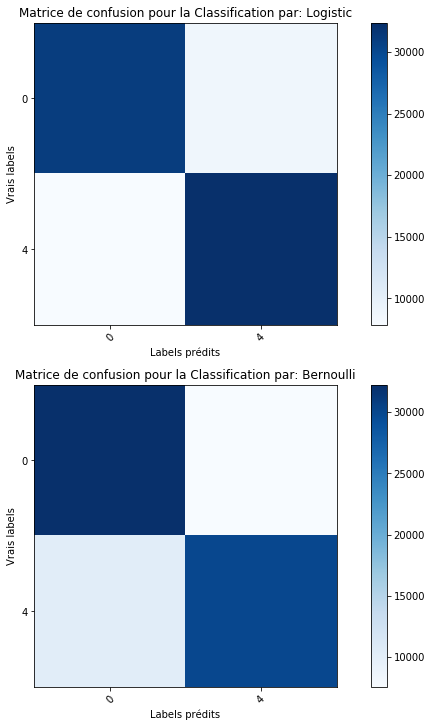

In [88]:
grid_confusion_matrix(prediction,y_test)

**Commentaire:** _Les matrices de confusion colorés reflètent bien les résulats des deux modèles._

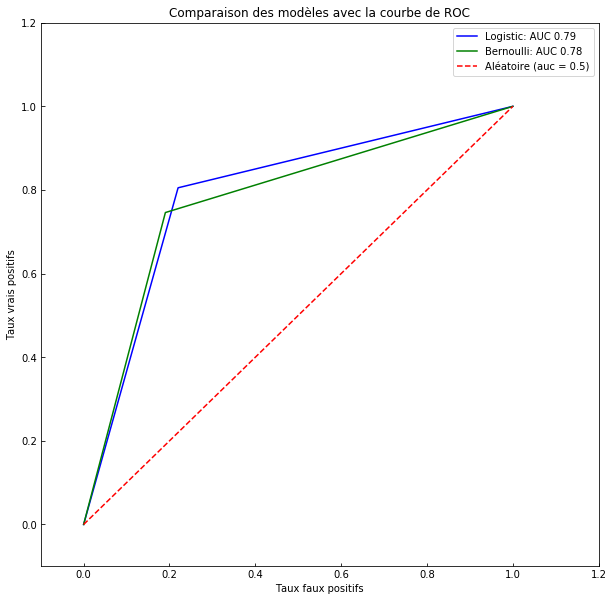

In [89]:
courbe_ROC(prediction,y_test)

**Commentaire:** _Ce graphique présente les deux courbes de ROC obtenues pour les deux modèles. Il confirme les résultats antérieurs avec des modèles assez performants que sont: la régression logistique et le naif bayésien._ 

## 2. Sur 800,000 tweets

On choisit 800,000 tweets du data:

In [90]:
df = pd.concat([data.iloc[0:400000,:], data.iloc[800000:1200000,:]], axis = 0).reset_index(drop = True)

### i. Les informations du <code>df</code>:

In [91]:
check_df(df)

Le nombre de tweets positifs est: 400000
Le nombre de tweets négatifs est: 400000
Le nombre de tweets nuls:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64
Nombre de retweets: 0


**Commentaire:** 
    - Notre jeu de données est bien équilibré entre les tweets postifs et les tweets négatifs.
    - Notre jeu de données ne comporte pas de valeurs manquantes.
    - Il n'y donc pas de retweets dans notre jeu de données.

### ii. Entraînement et évaluation de deux modèles de classification sur <code>df</code>

In [92]:
prediction, y_test = train_and_test_models(df)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Evaluation détaillée de la Classification par régression logistique :
 
               precision    recall  f1-score   support

           0       0.81      0.78      0.79     79909
           4       0.79      0.82      0.80     80091

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000

La matrice de confusion pour la Classification par régression logistique :
 
 Classe prédite      0      4
Classe réelle               
0               62315  17594
4               14712  65379
Le score pour la Classification par régression logistique : 0.7980875
Evaluation détaillée de la Classification par le modèle naif bayésien BernoulliNB :
 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79     79909
           4       0.80      0.76      0.78     80091

    accuracy                           0.78    160000
   macro avg       0.78      0.

**Commentaire:** 
    - Le modèle de régression logistique fournit des résultats très satisfaisants. Les résultats obtenus avec le modèle naif bayésien BernoulliNB sont également satisfaisants. 
    - Le score, la précision et le recall obtenus sont corrects.

### iii.Comparaison des modèles

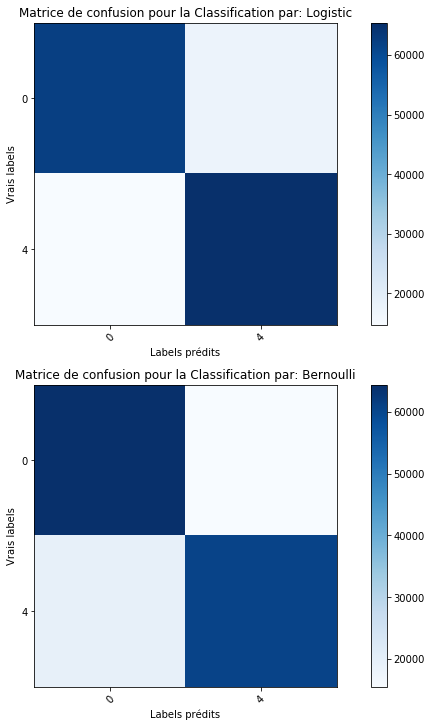

In [93]:
grid_confusion_matrix(prediction,y_test)

**Commentaire:** _Les matrices de confusion colorés reflètent bien les résulats des deux modèles._

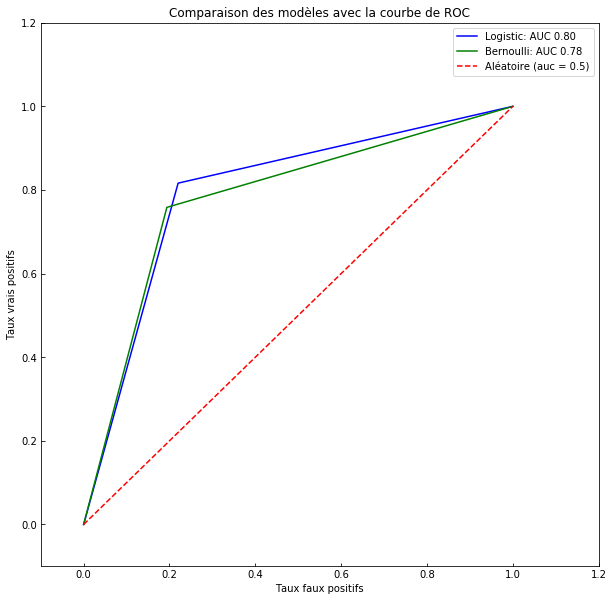

In [94]:
courbe_ROC(prediction,y_test)

**Commentaire:** _Ce graphique présente les deux courbes de ROC obtenues pour les deux modèles. Il confirme les résultats antérieurs avec des modèles assez performants que sont: la régression logistique et le naif bayésien._ 

## 2. Sur 1,600,000 tweets

On choisit 1,600,000 tweets du data (tous les tweets dans le jeu des données):

In [95]:
df = data

### i. Les informations du <code>df</code>:

In [96]:
check_df(df)

Le nombre de tweets positifs est: 800000
Le nombre de tweets négatifs est: 800000
Le nombre de tweets nuls:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64
Nombre de retweets: 0


**Commentaire:** 
    - Notre jeu de données est bien équilibré entre les tweets postifs et les tweets négatifs.
    - Notre jeu de données ne comporte pas de valeurs manquantes.
    - Il n'y donc pas de retweets dans notre jeu de données.

### ii. Entraînement et évaluation de deux modèles de classification sur <code>df</code>

In [97]:
prediction, y_test = train_and_test_models(df)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Evaluation détaillée de la Classification par régression logistique :
 
               precision    recall  f1-score   support

           0       0.81      0.78      0.80    159873
           4       0.79      0.82      0.80    160127

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

La matrice de confusion pour la Classification par régression logistique :
 
 Classe prédite       0       4
Classe réelle                 
0               125219   34654
4                29608  130519
Le score pour la Classification par régression logistique : 0.79918125
Evaluation détaillée de la Classification par le modèle naif bayésien BernoulliNB :
 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79    159873
           4       0.80      0.76      0.78    160127

    accuracy                           0.78    320000
   macro avg       0.7

**Commentaire:** 
    - Le modèle de régression logistique fournit des résultats très satisfaisants. Les résultats obtenus avec le modèle naif bayésien BernoulliNB sont également satisfaisants. 
    - Le score, la précision et le recall obtenus sont corrects.

### iii.Comparaison des modèles

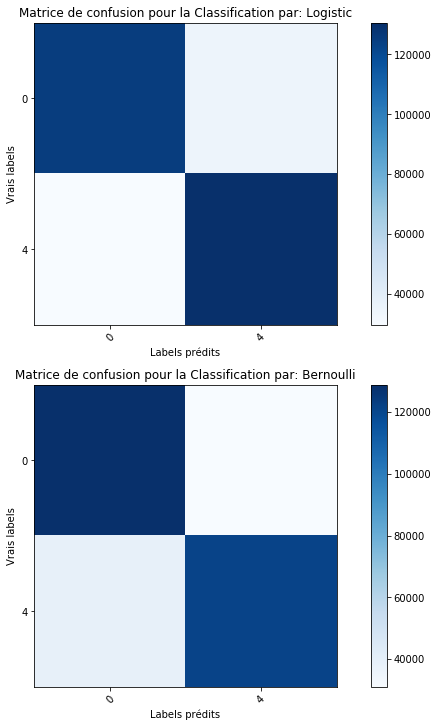

In [98]:
grid_confusion_matrix(prediction,y_test)

**Commentaire:** _Les matrices de confusion colorés reflètent bien les résulats des deux modèles._

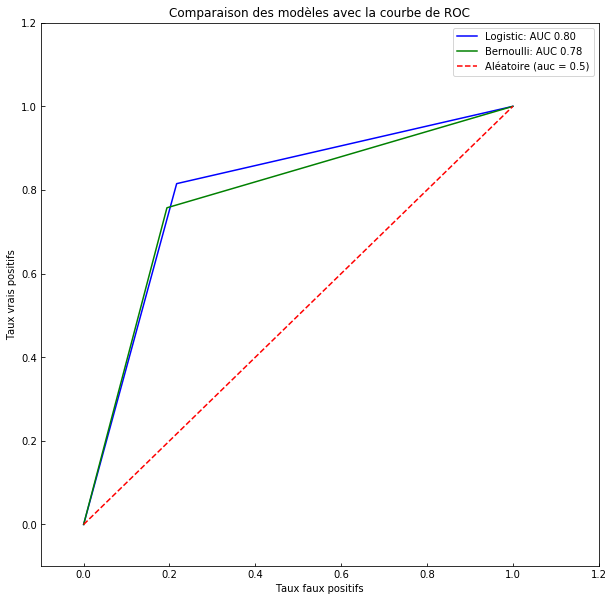

In [99]:
courbe_ROC(prediction,y_test)

**Commentaire:** _Ce graphique présente les deux courbes de ROC obtenues pour les deux modèles. Il confirme les résultats antérieurs avec des modèles assez performants que sont: la régression logistique et le naif bayésien._ 

**Commentaire:** _Pour conclure, on peut dire que l'augmentation du nombre de données du dataset n'améliore que légèrement les résultats obtenus avec un score qui frôle les 80% sur 1,600,000 tweets avec le modèle de régression logistique et une aire sous la courbe (AUC) de 0.8. Néanmoins, cette amélioration est assez faible par rapport aux résultats obtenus avec un dataset réduit à 200,000 tweets avec une score de 79% pour le même modèle. Le choix de réduire les données d'entraînement du modèle à 200,000 tweets paraît donc assez pertinent surtout en termes de gain en temps de calcul._ 